<a href="https://colab.research.google.com/github/jithsg/MODELING/blob/main/Model_1_pmos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iteration 1/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 2/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 3/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 4/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 5/6
Iteration 6/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


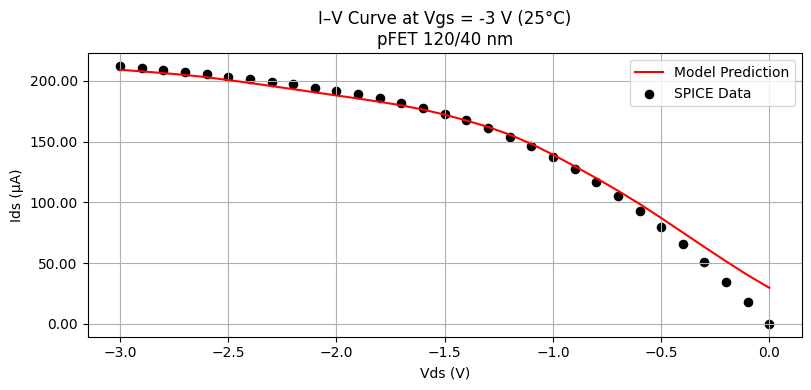

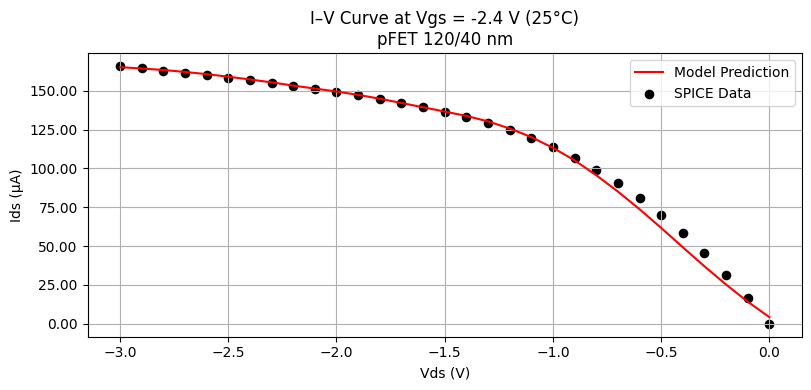

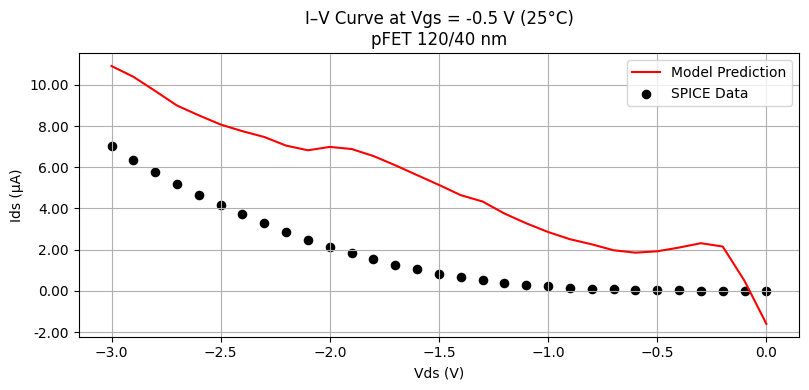

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.model_selection import GridSearchCV
from scipy.special import erf

# Load dataset
df = pd.read_csv('/content/pfet_120_40.csv')
df = df[df['Temp'] == 25].copy()
df.rename(columns={'Vgs(V)': 'Vgs', 'Vds(V)': 'Vds', 'Id(A)': 'Ids'}, inplace=True)

# Exclude some Vgs for testing
excluded_vgs = [-3, -2.4, -0.5]
df_train = df[~df['Vgs'].isin(excluded_vgs)].copy()
X = df_train[['Vgs', 'Vds']].values
y = df_train['Ids'].values.reshape(-1, 1)

# Standardize inputs and targets
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initial training subset
np.random.seed(42)
initial_indices = np.random.choice(len(X), size=30, replace=False)
X_train, y_train = X[initial_indices], y[initial_indices]

# Neural Network model
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(100, 50), (80, 40), (100, 80, 40)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [5000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

# Gaussian Process model
def create_gp_model():
    kernel = ConstantKernel(1.0, (1e-2, 10)) * (RBF(1.0) + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

# Acquisition function with diversity
def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    return 0.7 * ei + 0.3 * norm_dist

# Active Learning Loop
for i in range(6):
    print(f"Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_all_scaled = scaler_X.transform(X)
    y_nn_scaled = nn_model.predict(X_all_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X, X_train)
    new_indices = np.argsort(acq_values)[-5:]
    X_new = X[new_indices]
    y_new = y[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))

# Evaluate on excluded Vgs values
df_eval = df[df['Vgs'].isin(excluded_vgs)].copy()
X_eval = df_eval[['Vgs', 'Vds']].values
y_eval = df_eval['Ids'].values.reshape(-1, 1)

X_eval_scaled = scaler_X.transform(X_eval)
y_nn_scaled_eval = nn_model.predict(X_eval_scaled).reshape(-1, 1)
y_nn_eval = scaler_y.inverse_transform(y_nn_scaled_eval)
gp_corr_eval, _ = gp_model.predict(X_eval, return_std=True)
y_pred_eval = y_nn_eval + gp_corr_eval.reshape(-1, 1)

# Plot I-V curve for each excluded Vgs
for vgs_val in sorted(set(excluded_vgs)):
    subset = df_eval[df_eval['Vgs'] == vgs_val]
    y_true = subset['Ids'].values
    y_pred = y_pred_eval[df_eval['Vgs'] == vgs_val].flatten()
    vds_vals = subset['Vds'].values

    max_current = max(np.max(y_true), np.max(y_pred))
    if max_current >= 1e-3:
        scale_factor = 1e3
        unit_label = 'mA'
    else:
        scale_factor = 1e6
        unit_label = 'μA'

    plt.figure(figsize=(8, 4))
    plt.plot(vds_vals, y_pred * scale_factor, 'r-', label='Model Prediction')
    plt.scatter(vds_vals, y_true * scale_factor, color='k', s=35, marker='o', label='SPICE Data')
    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curve at Vgs = {vgs_val} V (25°C)\npFET 120/40 nm')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.show()


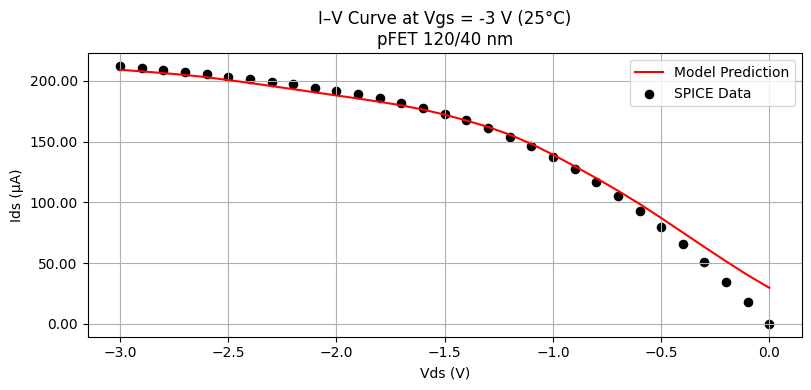

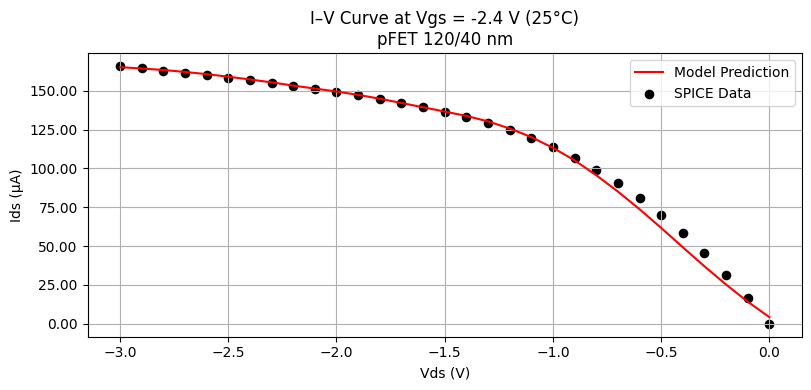

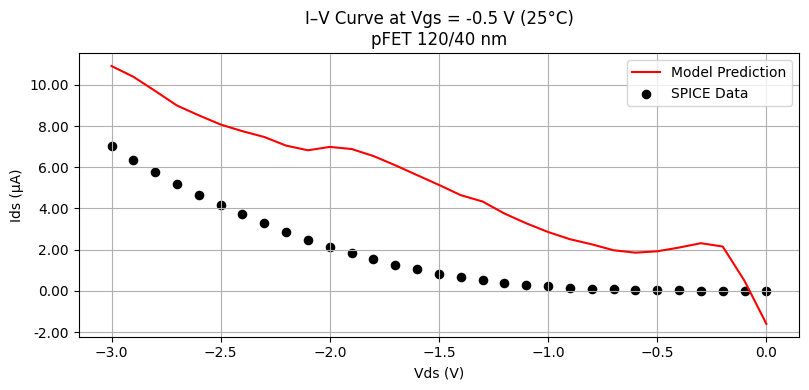

In [3]:
# Evaluate and plot predictions for excluded Vgs values

# Prepare evaluation set
df_eval = df[df['Vgs'].isin(excluded_vgs)].copy()
X_eval = df_eval[['Vgs', 'Vds']].values
y_eval = df_eval['Ids'].values.reshape(-1, 1)

# Predict
X_eval_scaled = scaler_X.transform(X_eval)
y_nn_scaled_eval = nn_model.predict(X_eval_scaled).reshape(-1, 1)
y_nn_eval = scaler_y.inverse_transform(y_nn_scaled_eval)
gp_corr_eval, _ = gp_model.predict(X_eval, return_std=True)
y_pred_eval = y_nn_eval + gp_corr_eval.reshape(-1, 1)

# Plot predictions vs SPICE for each excluded Vgs
for vgs_val in sorted(set(excluded_vgs)):
    subset = df_eval[df_eval['Vgs'] == vgs_val]
    y_true = subset['Ids'].values
    y_pred = y_pred_eval[df_eval['Vgs'] == vgs_val].flatten()
    vds_vals = subset['Vds'].values

    max_current = max(np.max(y_true), np.max(y_pred))
    if max_current >= 1e-3:
        scale_factor = 1e3
        unit_label = 'mA'
    else:
        scale_factor = 1e6
        unit_label = 'μA'

    plt.figure(figsize=(8, 4))
    plt.plot(vds_vals, y_pred * scale_factor, 'r-', label='Model Prediction')
    plt.scatter(vds_vals, y_true * scale_factor, color='k', s=35, marker='o', label='SPICE Data')
    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curve at Vgs = {vgs_val} V (25°C)\npFET 120/40 nm')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))

    plt.show()


Active Learning Iteration 1/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 2/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 3/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 4/6
Active Learning Iteration 5/6
Active Learning Iteration 6/6


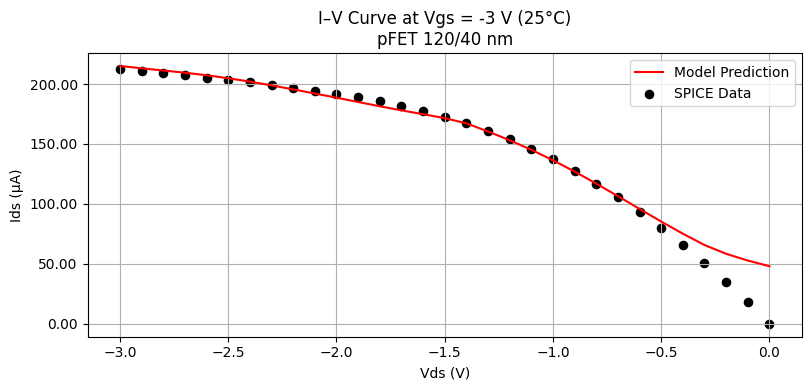

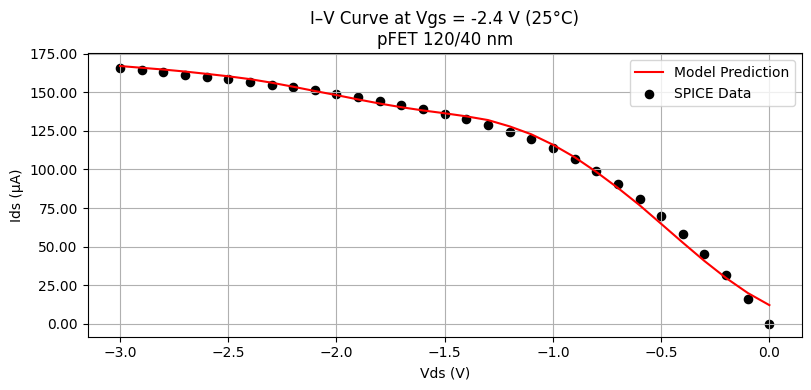

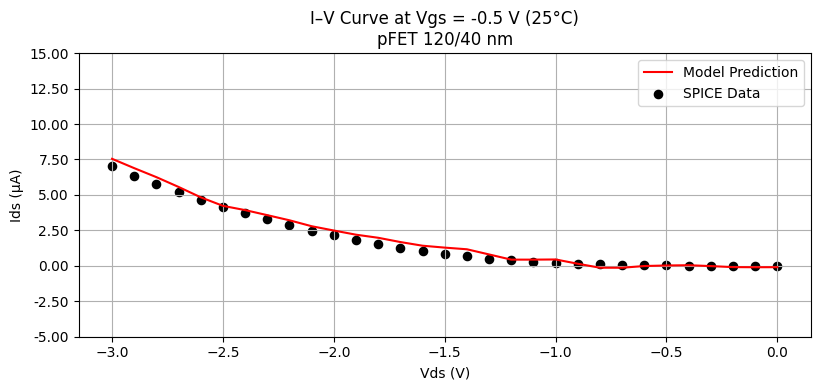

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.model_selection import GridSearchCV
from scipy.special import erf

# Load and filter data
df = pd.read_csv('/content/pfet_120_40.csv')
df = df[df['Temp'] == 25].copy()
df.rename(columns={'Vgs(V)': 'Vgs', 'Vds(V)': 'Vds', 'Id(A)': 'Ids'}, inplace=True)

excluded_vgs = [-0.5, -2.4, -3]
df_train = df[~df['Vgs'].isin(excluded_vgs)].copy()
X_full = df_train[['Vgs', 'Vds']].values
y_full = df_train['Ids'].values.reshape(-1, 1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initial training subset
np.random.seed(42)
initial_indices = np.random.choice(len(X_full), size=30, replace=False)
X_train = X_full[initial_indices]
y_train = y_full[initial_indices]

def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(100, 50), (80, 40)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [5000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

def create_gp_model():
    kernel = ConstantKernel(1.0, (1e-2, 10)) * (RBF(1.0) + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    vgs_focus = np.exp(-((X_pool[:, 0] + 0.5) ** 2) / (2 * 0.15 ** 2))
    return 0.6 * ei + 0.2 * norm_dist + 0.2 * vgs_focus

# Active Learning
for i in range(6):
    print(f"Active Learning Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_pool = X_full
    X_pool_scaled = scaler_X.transform(X_pool)
    y_nn_scaled = nn_model.predict(X_pool_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X_pool, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X_pool, X_train)
    new_indices = np.argsort(acq_values)[-5:]
    X_new = X_pool[new_indices]
    y_new = y_full[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))

# Evaluation
df_eval = df[df['Vgs'].isin(excluded_vgs)].copy()
X_eval = df_eval[['Vgs', 'Vds']].values
y_eval = df_eval['Ids'].values.reshape(-1, 1)

X_eval_scaled = scaler_X.transform(X_eval)
y_nn_scaled_eval = nn_model.predict(X_eval_scaled).reshape(-1, 1)
y_nn_eval = scaler_y.inverse_transform(y_nn_scaled_eval)
gp_corr_eval, _ = gp_model.predict(X_eval, return_std=True)
y_pred_eval = y_nn_eval + gp_corr_eval.reshape(-1, 1)

# Plotting
for vgs_val in sorted(set(excluded_vgs)):
    subset = df_eval[df_eval['Vgs'] == vgs_val]
    y_true = subset['Ids'].values
    y_pred = y_pred_eval[df_eval['Vgs'] == vgs_val].flatten()
    vds_vals = subset['Vds'].values

    max_current = max(np.max(y_true), np.max(y_pred))
    if max_current >= 1e-3:
        scale_factor = 1e3
        unit_label = 'mA'
    else:
        scale_factor = 1e6
        unit_label = 'μA'

    plt.figure(figsize=(8, 4))
    plt.plot(vds_vals, y_pred * scale_factor, 'r-', label='Model Prediction')
    plt.scatter(vds_vals, y_true * scale_factor, color='k', s=35, marker='o', label='SPICE Data')
    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curve at Vgs = {vgs_val} V (25°C)\npFET 120/40 nm')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Zoom out Y-axis for Vgs = –0.5V
    if vgs_val == -0.5:
        plt.ylim(-5, 15)  # Adjust as needed for μA range

    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.show()


Active Learning Iteration 1/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 2/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 3/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 4/6
Active Learning Iteration 5/6
Active Learning Iteration 6/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


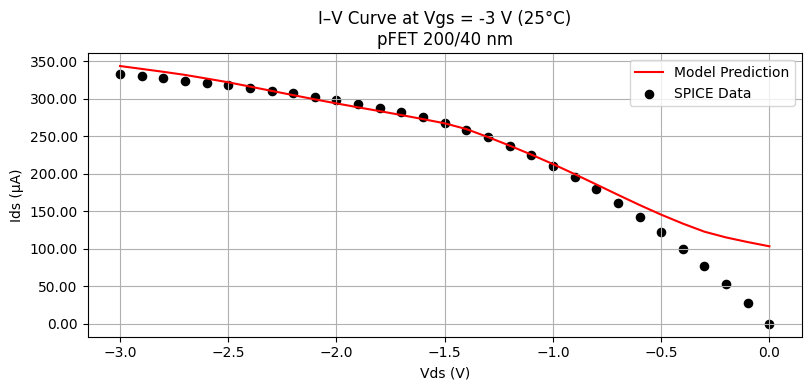

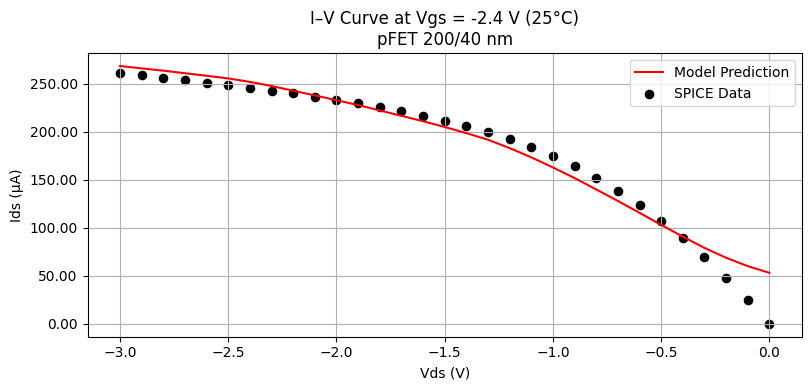

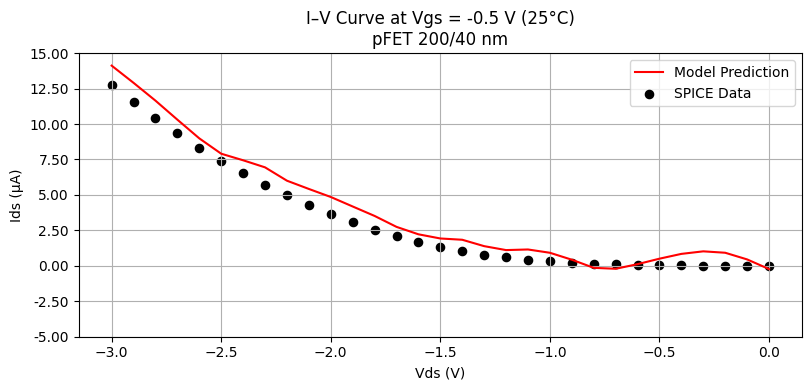

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.model_selection import GridSearchCV
from scipy.special import erf

# Load and filter data
df = pd.read_csv('/content/pfet_200_40.csv')
df = df[df['Temp'] == 25].copy()
df.rename(columns={'Vgs(V)': 'Vgs', 'Vds(V)': 'Vds', 'Id(A)': 'Ids'}, inplace=True)

excluded_vgs = [-0.5, -2.4, -3]
df_train = df[~df['Vgs'].isin(excluded_vgs)].copy()
X_full = df_train[['Vgs', 'Vds']].values
y_full = df_train['Ids'].values.reshape(-1, 1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initial training subset
np.random.seed(42)
initial_indices = np.random.choice(len(X_full), size=30, replace=False)
X_train = X_full[initial_indices]
y_train = y_full[initial_indices]

def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(100, 50), (80, 40)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [5000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

def create_gp_model():
    kernel = ConstantKernel(1.0, (1e-2, 10)) * (RBF(1.0) + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    vgs_focus = np.exp(-((X_pool[:, 0] + 0.5) ** 2) / (2 * 0.15 ** 2))
    return 0.6 * ei + 0.2 * norm_dist + 0.2 * vgs_focus

# Active Learning
for i in range(6):
    print(f"Active Learning Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_pool = X_full
    X_pool_scaled = scaler_X.transform(X_pool)
    y_nn_scaled = nn_model.predict(X_pool_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X_pool, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X_pool, X_train)
    new_indices = np.argsort(acq_values)[-5:]
    X_new = X_pool[new_indices]
    y_new = y_full[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))

# Evaluation
df_eval = df[df['Vgs'].isin(excluded_vgs)].copy()
X_eval = df_eval[['Vgs', 'Vds']].values
y_eval = df_eval['Ids'].values.reshape(-1, 1)

X_eval_scaled = scaler_X.transform(X_eval)
y_nn_scaled_eval = nn_model.predict(X_eval_scaled).reshape(-1, 1)
y_nn_eval = scaler_y.inverse_transform(y_nn_scaled_eval)
gp_corr_eval, _ = gp_model.predict(X_eval, return_std=True)
y_pred_eval = y_nn_eval + gp_corr_eval.reshape(-1, 1)

# Plotting
for vgs_val in sorted(set(excluded_vgs)):
    subset = df_eval[df_eval['Vgs'] == vgs_val]
    y_true = subset['Ids'].values
    y_pred = y_pred_eval[df_eval['Vgs'] == vgs_val].flatten()
    vds_vals = subset['Vds'].values

    max_current = max(np.max(y_true), np.max(y_pred))
    if max_current >= 1e-3:
        scale_factor = 1e3
        unit_label = 'mA'
    else:
        scale_factor = 1e6
        unit_label = 'μA'

    plt.figure(figsize=(8, 4))
    plt.plot(vds_vals, y_pred * scale_factor, 'r-', label='Model Prediction')
    plt.scatter(vds_vals, y_true * scale_factor, color='k', s=35, marker='o', label='SPICE Data')
    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curve at Vgs = {vgs_val} V (25°C)\npFET 200/40 nm')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Zoom out Y-axis for Vgs = –0.5V
    if vgs_val == -0.5:
        plt.ylim(-5, 15)  # Adjust as needed for μA range

    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.show()


Active Learning Iteration 1/6
Active Learning Iteration 2/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 3/6
Active Learning Iteration 4/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 5/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Active Learning Iteration 6/6


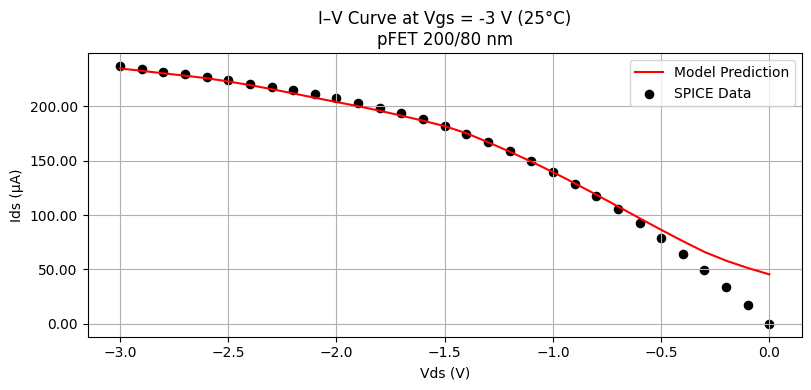

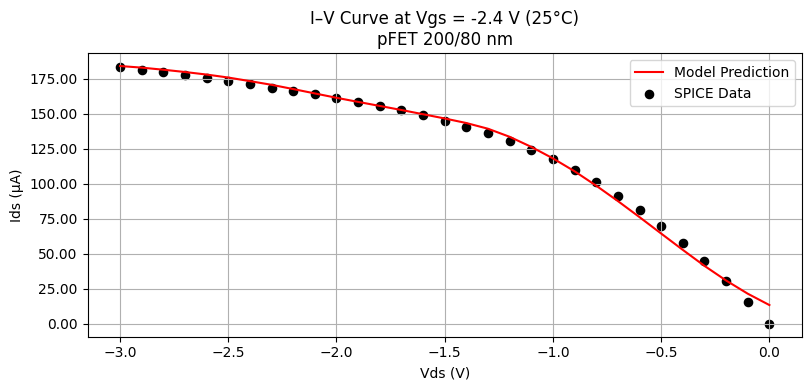

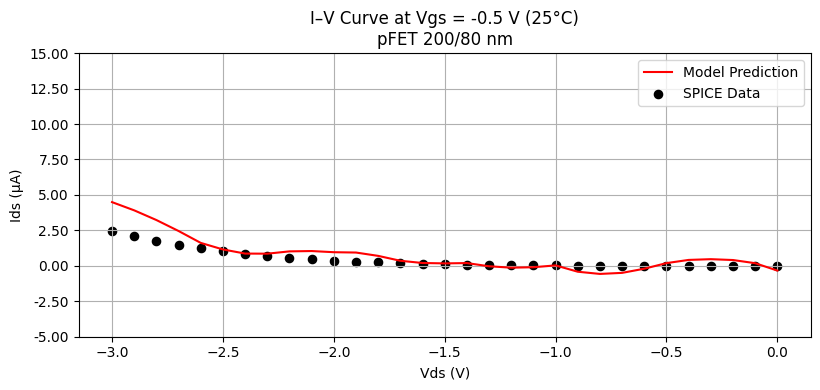

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.model_selection import GridSearchCV
from scipy.special import erf

# Load and filter data
df = pd.read_csv('/content/pfet_200_80.csv')
df = df[df['Temp'] == 25].copy()
df.rename(columns={'Vgs(V)': 'Vgs', 'Vds(V)': 'Vds', 'Id(A)': 'Ids'}, inplace=True)

excluded_vgs = [-0.5, -2.4, -3]
df_train = df[~df['Vgs'].isin(excluded_vgs)].copy()
X_full = df_train[['Vgs', 'Vds']].values
y_full = df_train['Ids'].values.reshape(-1, 1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initial training subset
np.random.seed(42)
initial_indices = np.random.choice(len(X_full), size=30, replace=False)
X_train = X_full[initial_indices]
y_train = y_full[initial_indices]

def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(100, 50), (80, 40)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [5000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

def create_gp_model():
    kernel = ConstantKernel(1.0, (1e-2, 10)) * (RBF(1.0) + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    vgs_focus = np.exp(-((X_pool[:, 0] + 0.5) ** 2) / (2 * 0.15 ** 2))
    return 0.6 * ei + 0.2 * norm_dist + 0.2 * vgs_focus

# Active Learning
for i in range(6):
    print(f"Active Learning Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_pool = X_full
    X_pool_scaled = scaler_X.transform(X_pool)
    y_nn_scaled = nn_model.predict(X_pool_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X_pool, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X_pool, X_train)
    new_indices = np.argsort(acq_values)[-5:]
    X_new = X_pool[new_indices]
    y_new = y_full[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))

# Evaluation
df_eval = df[df['Vgs'].isin(excluded_vgs)].copy()
X_eval = df_eval[['Vgs', 'Vds']].values
y_eval = df_eval['Ids'].values.reshape(-1, 1)

X_eval_scaled = scaler_X.transform(X_eval)
y_nn_scaled_eval = nn_model.predict(X_eval_scaled).reshape(-1, 1)
y_nn_eval = scaler_y.inverse_transform(y_nn_scaled_eval)
gp_corr_eval, _ = gp_model.predict(X_eval, return_std=True)
y_pred_eval = y_nn_eval + gp_corr_eval.reshape(-1, 1)

# Plotting
for vgs_val in sorted(set(excluded_vgs)):
    subset = df_eval[df_eval['Vgs'] == vgs_val]
    y_true = subset['Ids'].values
    y_pred = y_pred_eval[df_eval['Vgs'] == vgs_val].flatten()
    vds_vals = subset['Vds'].values

    max_current = max(np.max(y_true), np.max(y_pred))
    if max_current >= 1e-3:
        scale_factor = 1e3
        unit_label = 'mA'
    else:
        scale_factor = 1e6
        unit_label = 'μA'

    plt.figure(figsize=(8, 4))
    plt.plot(vds_vals, y_pred * scale_factor, 'r-', label='Model Prediction')
    plt.scatter(vds_vals, y_true * scale_factor, color='k', s=35, marker='o', label='SPICE Data')
    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curve at Vgs = {vgs_val} V (25°C)\npFET 200/80 nm')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Zoom out Y-axis for Vgs = –0.5V
    if vgs_val == -0.5:
        plt.ylim(-5, 15)  # Adjust as needed for μA range

    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.show()


Active Learning Iteration 1/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 2/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 3/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 4/6
Active Learning Iteration 5/6
Active Learning Iteration 6/6


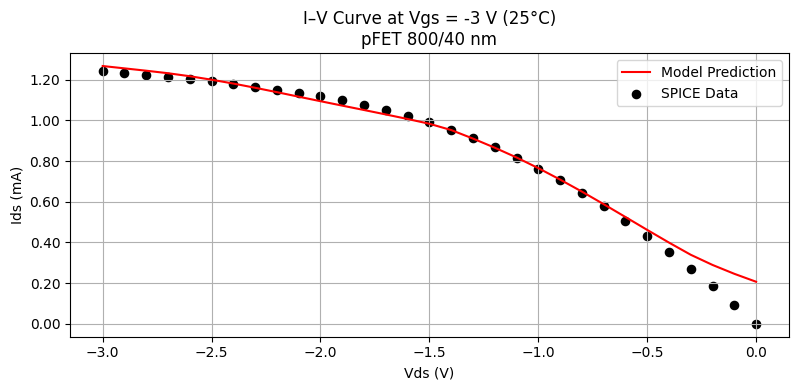

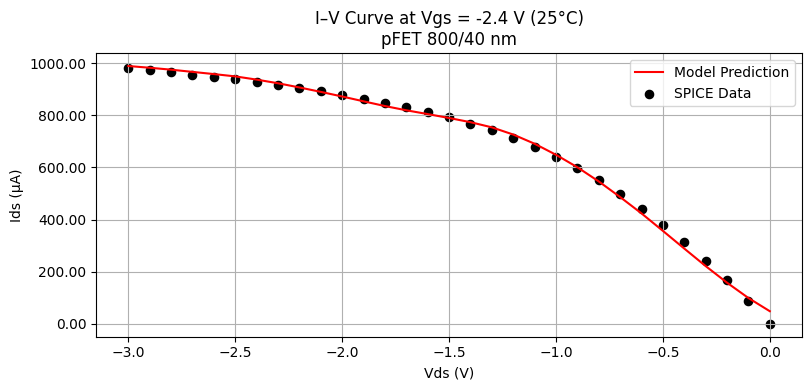

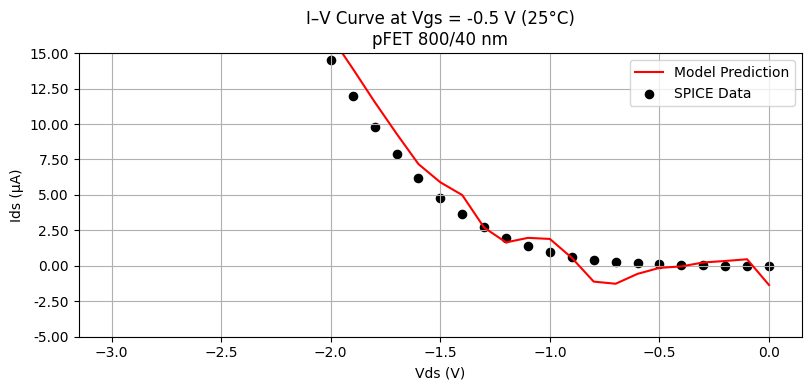

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.model_selection import GridSearchCV
from scipy.special import erf

# Load and filter data
df = pd.read_csv('/content/pfet_800_40.csv')
df = df[df['Temp'] == 25].copy()
df.rename(columns={'Vgs(V)': 'Vgs', 'Vds(V)': 'Vds', 'Id(A)': 'Ids'}, inplace=True)

excluded_vgs = [-0.5, -2.4, -3]
df_train = df[~df['Vgs'].isin(excluded_vgs)].copy()
X_full = df_train[['Vgs', 'Vds']].values
y_full = df_train['Ids'].values.reshape(-1, 1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initial training subset
np.random.seed(42)
initial_indices = np.random.choice(len(X_full), size=30, replace=False)
X_train = X_full[initial_indices]
y_train = y_full[initial_indices]

def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(100, 50), (80, 40)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [5000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

def create_gp_model():
    kernel = ConstantKernel(1.0, (1e-2, 10)) * (RBF(1.0) + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    vgs_focus = np.exp(-((X_pool[:, 0] + 0.5) ** 2) / (2 * 0.15 ** 2))
    return 0.6 * ei + 0.2 * norm_dist + 0.2 * vgs_focus

# Active Learning
for i in range(6):
    print(f"Active Learning Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_pool = X_full
    X_pool_scaled = scaler_X.transform(X_pool)
    y_nn_scaled = nn_model.predict(X_pool_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X_pool, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X_pool, X_train)
    new_indices = np.argsort(acq_values)[-5:]
    X_new = X_pool[new_indices]
    y_new = y_full[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))

# Evaluation
df_eval = df[df['Vgs'].isin(excluded_vgs)].copy()
X_eval = df_eval[['Vgs', 'Vds']].values
y_eval = df_eval['Ids'].values.reshape(-1, 1)

X_eval_scaled = scaler_X.transform(X_eval)
y_nn_scaled_eval = nn_model.predict(X_eval_scaled).reshape(-1, 1)
y_nn_eval = scaler_y.inverse_transform(y_nn_scaled_eval)
gp_corr_eval, _ = gp_model.predict(X_eval, return_std=True)
y_pred_eval = y_nn_eval + gp_corr_eval.reshape(-1, 1)

# Plotting
for vgs_val in sorted(set(excluded_vgs)):
    subset = df_eval[df_eval['Vgs'] == vgs_val]
    y_true = subset['Ids'].values
    y_pred = y_pred_eval[df_eval['Vgs'] == vgs_val].flatten()
    vds_vals = subset['Vds'].values

    max_current = max(np.max(y_true), np.max(y_pred))
    if max_current >= 1e-3:
        scale_factor = 1e3
        unit_label = 'mA'
    else:
        scale_factor = 1e6
        unit_label = 'μA'

    plt.figure(figsize=(8, 4))
    plt.plot(vds_vals, y_pred * scale_factor, 'r-', label='Model Prediction')
    plt.scatter(vds_vals, y_true * scale_factor, color='k', s=35, marker='o', label='SPICE Data')
    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curve at Vgs = {vgs_val} V (25°C)\npFET 800/40 nm')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Zoom out Y-axis for Vgs = –0.5V
    if vgs_val == -0.5:
        plt.ylim(-5, 15)  # Adjust as needed for μA range

    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.show()


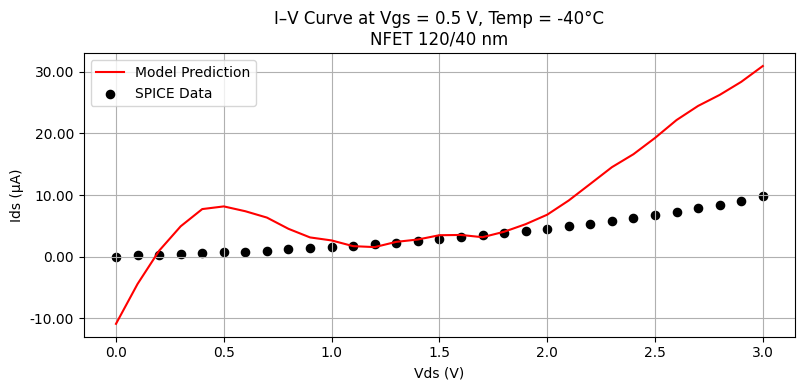

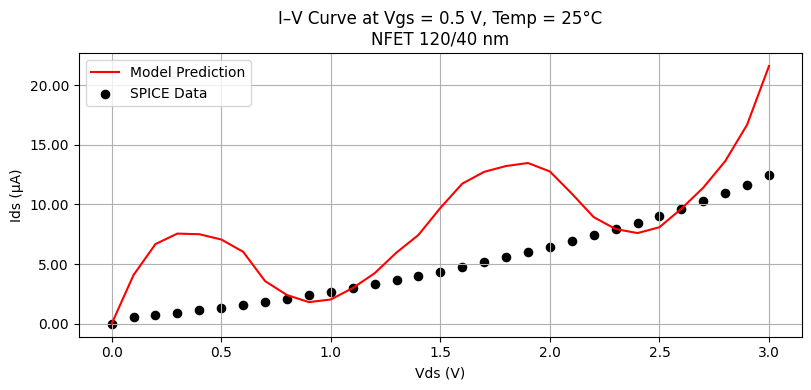

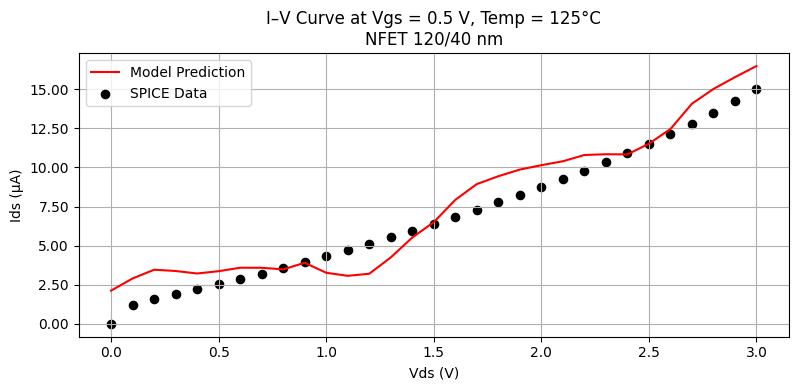

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from scipy.special import erf

# Load and clean data
df = pd.read_csv('/content/nfet_120_40.CSV')
df = df[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['Temp', 'Vgs', 'Vds', 'Ids']

# Use Temp as input along with Vgs, Vds
X = df[['Vgs', 'Vds', 'Temp']].values
y = df['Ids'].values.reshape(-1, 1)

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initial training data
np.random.seed(42)
initial_indices = np.random.choice(len(X), size=100, replace=False)
X_train = X[initial_indices]
y_train = y[initial_indices]

# Define NN model
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(100, 50), (80, 40)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [5000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

# Define GP model
def create_gp_model():
    kernel = ConstantKernel(1.0, (1e-2, 10)) * (RBF() + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

# Train model
X_scaled = scaler_X.fit_transform(X_train)
y_scaled = scaler_y.fit_transform(y_train)
nn_model = create_nn_model(X_train, y_train)
nn_model.fit(X_scaled, y_scaled.ravel())

# Predict NN output and residuals
X_all_scaled = scaler_X.transform(X)
y_nn_scaled = nn_model.predict(X_all_scaled).reshape(-1, 1)
y_nn = scaler_y.inverse_transform(y_nn_scaled)

y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
residuals = y_train - y_train_pred

# Train GP on residuals
gp_model = create_gp_model()
gp_model.fit(X_train, residuals.ravel())

# Final prediction
gp_corr, gp_std = gp_model.predict(X, return_std=True)
y_pred_final = y_nn + gp_corr.reshape(-1, 1)

# Plot at different temperatures and Vgs values
temps = [-40, 25, 125]
vgs_targets = [0.5, 1.5, 2.5]

for temp in temps:
    for vgs in vgs_targets:
        mask = (df['Temp'] == temp) & (np.isclose(df['Vgs'], vgs))
        subset = df[mask]
        if subset.empty:
            continue
        X_eval = subset[['Vgs', 'Vds', 'Temp']].values
        y_true = subset['Ids'].values
        X_eval_scaled = scaler_X.transform(X_eval)
        y_nn_scaled_eval = nn_model.predict(X_eval_scaled).reshape(-1, 1)
        y_nn_eval = scaler_y.inverse_transform(y_nn_scaled_eval)
        gp_corr_eval, _ = gp_model.predict(X_eval, return_std=True)
        y_pred = y_nn_eval + gp_corr_eval.reshape(-1, 1)

        max_current = max(np.max(y_true), np.max(y_pred))
        scale_factor = 1e3 if max_current >= 1e-3 else 1e6
        unit_label = 'mA' if scale_factor == 1e3 else 'μA'

        plt.figure(figsize=(8, 4))
        plt.plot(subset['Vds'], y_pred.flatten() * scale_factor, 'r-', label='Model Prediction')
        plt.scatter(subset['Vds'], y_true * scale_factor, color='k', s=35, marker='o', label='SPICE Data')
        plt.xlabel('Vds (V)')
        plt.ylabel(f'Ids ({unit_label})')
        plt.title(f'I–V Curve at Vgs = {vgs} V, Temp = {temp}°C\nNFET 120/40 nm')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        ax = plt.gca()
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
        plt.show()


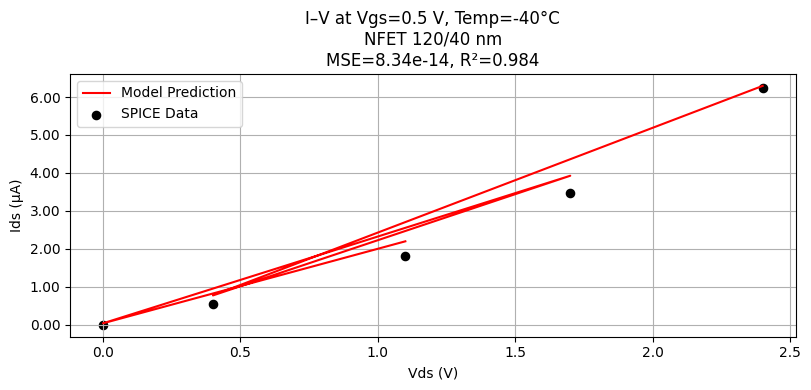

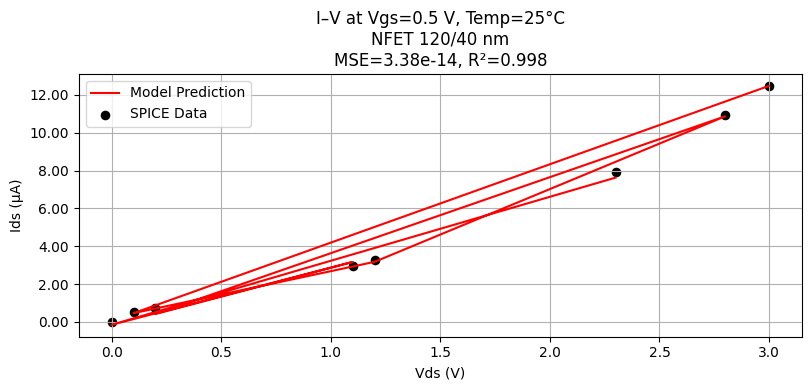

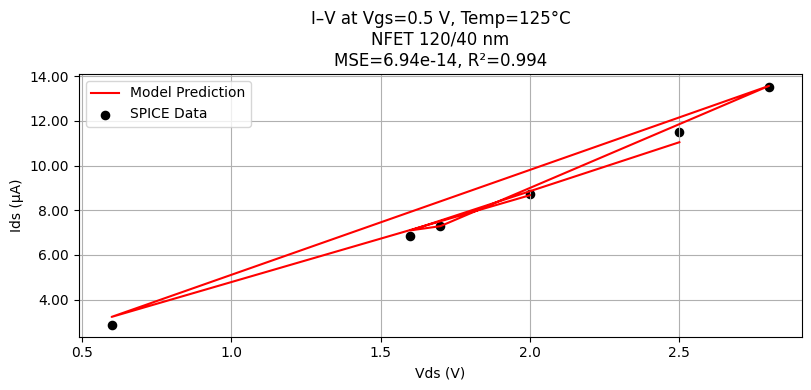

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score

# Load data
df = pd.read_csv('/content/nfet_120_40.CSV')
df = df[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['Temp', 'Vgs', 'Vds', 'Ids']

# Prepare input/output
X = df[['Vgs', 'Vds', 'Temp']].values
y = df['Ids'].values.reshape(-1, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Train NN
param_grid = {
    'hidden_layer_sizes': [(100, 50)],
    'alpha': [0.001],
    'learning_rate': ['adaptive'],
    'max_iter': [5000]
}
nn_model = MLPRegressor(random_state=42, early_stopping=True)
grid = GridSearchCV(nn_model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid.fit(X_train_scaled, y_train_scaled.ravel())
nn_model = grid.best_estimator_

# Residuals and GP training
y_train_pred_scaled = nn_model.predict(X_train_scaled).reshape(-1, 1)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
residuals = y_train - y_train_pred
gp_model = GaussianProcessRegressor(
    kernel=ConstantKernel(1.0) * (RBF() + RationalQuadratic()) + WhiteKernel(noise_level=1e-5),
    alpha=1e-6, normalize_y=True, n_restarts_optimizer=5
)
gp_model.fit(X_train, residuals.ravel())

# Prepare test DataFrame
df_test = pd.DataFrame(X_test, columns=['Vgs', 'Vds', 'Temp'])
df_test['Ids'] = y_test

# Evaluate on selected Vgs and Temp values
temps = [-40, 25, 125]
vgs_values = [0.5, 1.5, 2.5]

for temp in temps:
    for vgs in vgs_values:
        subset = df_test[(np.isclose(df_test['Temp'], temp)) & (np.isclose(df_test['Vgs'], vgs))]
        if subset.empty:
            continue

        X_eval = subset[['Vgs', 'Vds', 'Temp']].values
        y_true = subset['Ids'].values

        X_eval_scaled = scaler_X.transform(X_eval)
        y_nn_scaled = nn_model.predict(X_eval_scaled).reshape(-1, 1)
        y_nn = scaler_y.inverse_transform(y_nn_scaled)
        gp_corr, _ = gp_model.predict(X_eval, return_std=True)
        y_pred = y_nn + gp_corr.reshape(-1, 1)

        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        scale_factor = 1e3 if np.max(y_pred) >= 1e-3 else 1e6
        unit_label = 'mA' if scale_factor == 1e3 else 'μA'

        plt.figure(figsize=(8, 4))
        plt.plot(subset['Vds'], y_pred.flatten() * scale_factor, 'r-', label='Model Prediction')
        plt.scatter(subset['Vds'], y_true * scale_factor, color='k', s=35, marker='o', label='SPICE Data')
        plt.xlabel('Vds (V)')
        plt.ylabel(f'Ids ({unit_label})')
        plt.title(f'I–V at Vgs={vgs} V, Temp={temp}°C\nNFET 120/40 nm\nMSE={mse:.2e}, R²={r2:.3f}')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        ax = plt.gca()
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
        plt.show()


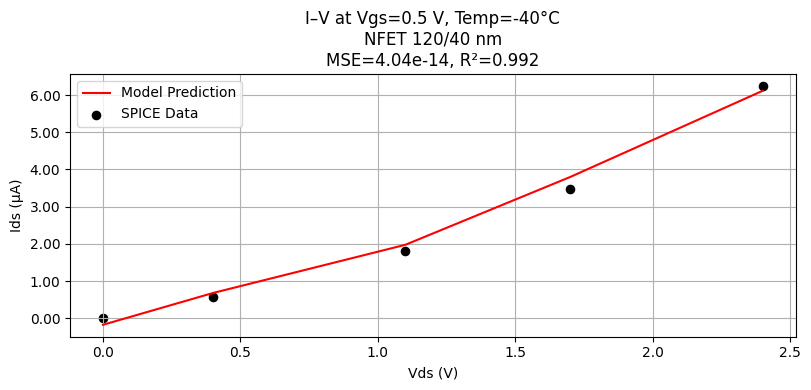

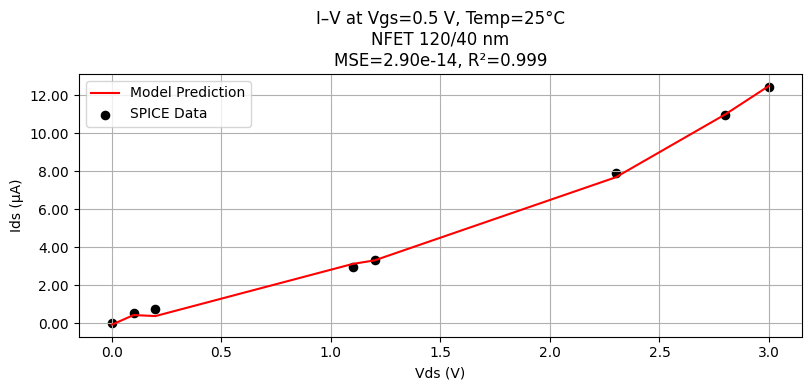

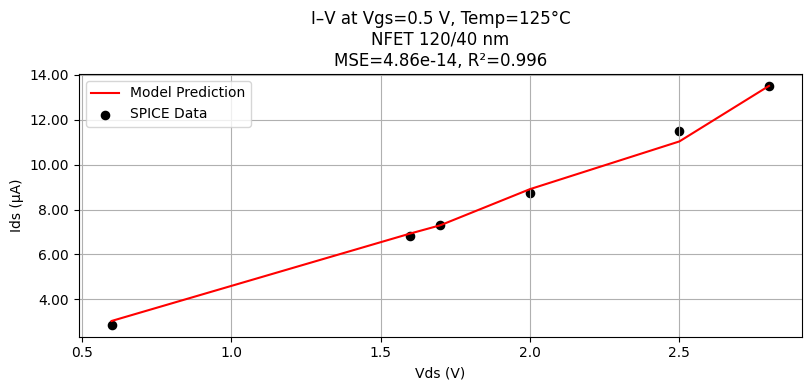

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv('/content/nfet_120_40.CSV')
df = df[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['Temp', 'Vgs', 'Vds', 'Ids']

# Prepare input/output
X = df[['Vgs', 'Vds', 'Temp']].values
y = df['Ids'].values.reshape(-1, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Train NN
param_grid = {
    'hidden_layer_sizes': [(100, 50)],
    'alpha': [0.001],
    'learning_rate': ['adaptive'],
    'max_iter': [5000]
}
nn_model = MLPRegressor(random_state=42, early_stopping=True)
grid = GridSearchCV(nn_model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid.fit(X_train_scaled, y_train_scaled.ravel())
nn_model = grid.best_estimator_

# Train GP on residuals
y_train_pred_scaled = nn_model.predict(X_train_scaled).reshape(-1, 1)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
residuals = y_train - y_train_pred

gp_model = GaussianProcessRegressor(
    kernel=ConstantKernel(1.0) * (RBF() + RationalQuadratic()) + WhiteKernel(noise_level=1e-5),
    alpha=1e-6, normalize_y=True, n_restarts_optimizer=5
)
gp_model.fit(X_train, residuals.ravel())

# Create test DataFrame
df_test = pd.DataFrame(X_test, columns=['Vgs', 'Vds', 'Temp'])
df_test['Ids'] = y_test

# Evaluate at selected temperatures and Vgs values
temps = [-40, 25, 125]
vgs_values = [0.5, 1.5, 2.5]

for temp in temps:
    for vgs in vgs_values:
        subset = df_test[(np.isclose(df_test['Temp'], temp)) & (np.isclose(df_test['Vgs'], vgs))]
        if subset.empty:
            continue

        X_eval = subset[['Vgs', 'Vds', 'Temp']].values
        y_true = subset['Ids'].values

        X_eval_scaled = scaler_X.transform(X_eval)
        y_nn_scaled = nn_model.predict(X_eval_scaled).reshape(-1, 1)
        y_nn = scaler_y.inverse_transform(y_nn_scaled)
        gp_corr, _ = gp_model.predict(X_eval, return_std=True)
        y_pred = y_nn + gp_corr.reshape(-1, 1)

        # Sort Vds and corresponding predictions for proper plotting
        sorted_idx = np.argsort(subset['Vds'].values)
        vds_sorted = subset['Vds'].values[sorted_idx]
        y_true_sorted = y_true[sorted_idx]
        y_pred_sorted = y_pred.flatten()[sorted_idx]

        # Scale units
        max_current = max(np.max(y_true_sorted), np.max(y_pred_sorted))
        scale_factor = 1e3 if max_current >= 1e-3 else 1e6
        unit_label = 'mA' if scale_factor == 1e3 else 'μA'

        # Metrics
        mse = mean_squared_error(y_true_sorted, y_pred_sorted)
        r2 = r2_score(y_true_sorted, y_pred_sorted)

        # Plot
        plt.figure(figsize=(8, 4))
        plt.plot(vds_sorted, y_pred_sorted * scale_factor, 'r-', label='Model Prediction')
        plt.scatter(vds_sorted, y_true_sorted * scale_factor, color='k', s=35, marker='o', label='SPICE Data')
        plt.xlabel('Vds (V)')
        plt.ylabel(f'Ids ({unit_label})')
        plt.title(f'I–V at Vgs={vgs} V, Temp={temp}°C\nNFET 120/40 nm\nMSE={mse:.2e}, R²={r2:.3f}')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        ax = plt.gca()
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
        plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.model_selection import GridSearchCV
from scipy.special import erf

# Load and preprocess data
df = pd.read_csv('pfet_800_40.csv')
df = df[df['Temp'] == 25].copy()
df.rename(columns={'Vgs(V)': 'Vgs', 'Vds(V)': 'Vds', 'Id(A)': 'Ids'}, inplace=True)

excluded_vgs = [-0.5, -2.4, -3.0]
df_train = df[~df['Vgs'].isin(excluded_vgs)].copy()
X_full = df_train[['Vgs', 'Vds']].values
y_full = df_train['Ids'].values.reshape(-1, 1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

np.random.seed(42)
initial_indices = np.random.choice(len(X_full), size=30, replace=False)
X_train = X_full[initial_indices]
y_train = y_full[initial_indices]

def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(100, 50), (80, 40)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [5000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

def create_gp_model():
    kernel = ConstantKernel(1.0, (1e-2, 10)) * (RBF(1.0) + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    vgs_focus = np.exp(-((X_pool[:, 0] + 0.5) ** 2) / (2 * 0.15 ** 2))
    return 0.6 * ei + 0.2 * norm_dist + 0.2 * vgs_focus

# Active Learning Loop
for i in range(6):
    print(f"Active Learning Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_pool = X_full
    X_pool_scaled = scaler_X.transform(X_pool)
    y_nn_scaled = nn_model.predict(X_pool_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X_pool, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X_pool, X_train)
    new_indices = np.argsort(acq_values)[-5:]
    X_new = X_pool[new_indices]
    y_new = y_full[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))

# Evaluation
df_eval = df[df['Vgs'].isin(excluded_vgs)].copy()
X_eval = df_eval[['Vgs', 'Vds']].values
y_eval = df_eval['Ids'].values.reshape(-1, 1)

X_eval_scaled = scaler_X.transform(X_eval)
y_nn_scaled_eval = nn_model.predict(X_eval_scaled).reshape(-1, 1)
y_nn_eval = scaler_y.inverse_transform(y_nn_scaled_eval)
gp_corr_eval, _ = gp_model.predict(X_eval, return_std=True)
y_pred_eval = y_nn_eval + gp_corr_eval.reshape(-1, 1)

# Plotting
for vgs_val in sorted(set(excluded_vgs)):
    subset = df_eval[df_eval['Vgs'] == vgs_val]
    y_true = subset['Ids'].values
    y_pred = y_pred_eval[df_eval['Vgs'] == vgs_val].flatten()
    vds_vals = subset['Vds'].values

    max_current = max(np.max(y_true), np.max(y_pred))
    if max_current >= 1e-3:
        scale_factor = 1e3
        unit_label = 'mA'
    else:
        scale_factor = 1e6
        unit_label = 'μA'

    plt.figure(figsize=(8, 4))
    plt.plot(vds_vals, y_pred * scale_factor, 'r-', label='Model Prediction')
    plt.scatter(vds_vals, y_pred * scale_factor, color='red', s=30, marker='x', label='Predicted Points')
    plt.scatter(vds_vals, y_true * scale_factor, color='black', s=35, marker='o', label='SPICE Data')
    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curve at Vgs = {vgs_val} V (25°C)\npFET 800/40 nm')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    if vgs_val == -0.5:
        plt.ylim(-5, 15)

    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.show()


Active Learning Iteration 1/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 2/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 3/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 4/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 5/6
Active Learning Iteration 6/6


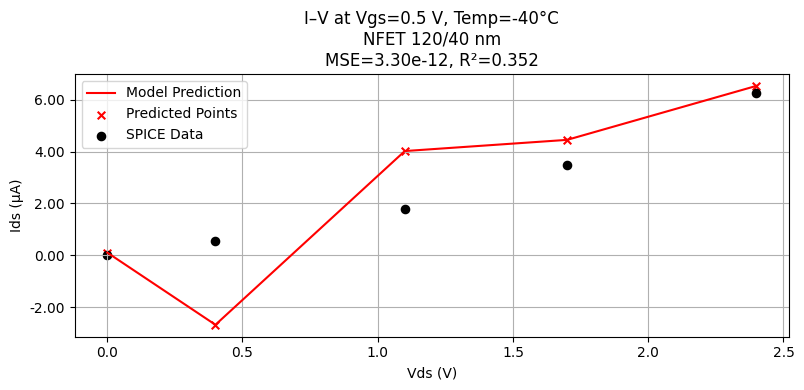

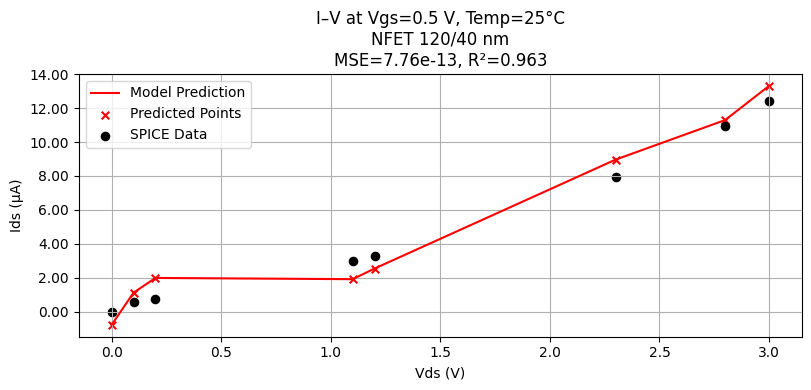

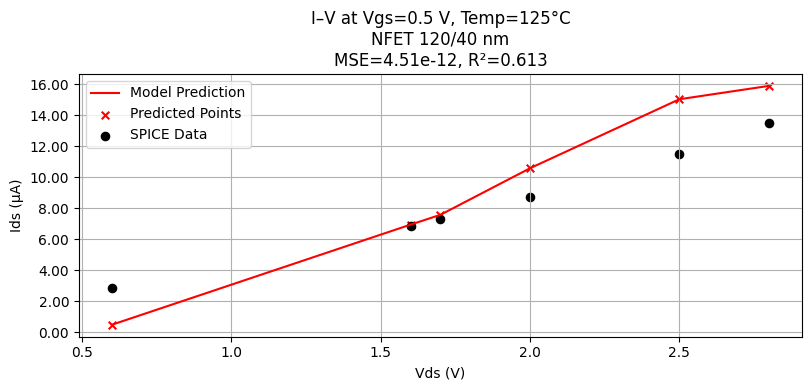

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
from scipy.special import erf

# Load dataset
df = pd.read_csv('/content/nfet_120_40.CSV')
df = df[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['Temp', 'Vgs', 'Vds', 'Ids']

# Create input and output arrays
X_full = df[['Vgs', 'Vds', 'Temp']].values
y_full = df['Ids'].values.reshape(-1, 1)

# Split into disjoint training and evaluation sets
X_pool, X_eval, y_pool, y_eval = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initialize with a small training subset from X_pool
np.random.seed(42)
initial_indices = np.random.choice(len(X_pool), size=100, replace=False)
X_train = X_pool[initial_indices]
y_train = y_pool[initial_indices]

# Define models
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(100, 50), (80, 40)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [5000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

def create_gp_model():
    kernel = ConstantKernel(1.0) * (RBF() + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    temp_focus = np.exp(-((X_pool[:, 2] - 25.0) ** 2) / (2 * 50 ** 2))
    return 0.6 * ei + 0.2 * norm_dist + 0.2 * temp_focus

# Active Learning Loop
for i in range(6):
    print(f"Active Learning Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_pool_scaled = scaler_X.transform(X_pool)
    y_nn_scaled = nn_model.predict(X_pool_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X_pool, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X_pool, X_train)
    new_indices = np.argsort(acq_values)[-10:]
    X_new = X_pool[new_indices]
    y_new = y_pool[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))

# Evaluate on X_eval
df_test = pd.DataFrame(X_eval, columns=['Vgs', 'Vds', 'Temp'])
df_test['Ids'] = y_eval.flatten()
temps = [-40, 25, 125]
vgs_values = [0.5, 1.5, 2.5]

for temp in temps:
    for vgs in vgs_values:
        subset = df_test[(np.isclose(df_test['Temp'], temp)) & (np.isclose(df_test['Vgs'], vgs))]
        if subset.empty:
            continue

        X_eval_subset = subset[['Vgs', 'Vds', 'Temp']].values
        y_true = subset['Ids'].values

        X_eval_scaled = scaler_X.transform(X_eval_subset)
        y_nn_scaled = nn_model.predict(X_eval_scaled).reshape(-1, 1)
        y_nn = scaler_y.inverse_transform(y_nn_scaled)
        gp_corr, _ = gp_model.predict(X_eval_subset, return_std=True)
        y_pred = y_nn + gp_corr.reshape(-1, 1)

        sorted_idx = np.argsort(subset['Vds'].values)
        vds_sorted = subset['Vds'].values[sorted_idx]
        y_true_sorted = y_true[sorted_idx]
        y_pred_sorted = y_pred.flatten()[sorted_idx]

        max_current = max(np.max(y_true_sorted), np.max(y_pred_sorted))
        scale_factor = 1e3 if max_current >= 1e-3 else 1e6
        unit_label = 'mA' if scale_factor == 1e3 else 'μA'

        mse = mean_squared_error(y_true_sorted, y_pred_sorted)
        r2 = r2_score(y_true_sorted, y_pred_sorted)

        plt.figure(figsize=(8, 4))
        plt.plot(vds_sorted, y_pred_sorted * scale_factor, 'r-', label='Model Prediction')
        plt.scatter(vds_sorted, y_pred_sorted * scale_factor, color='red', s=30, marker='x', label='Predicted Points')
        plt.scatter(vds_sorted, y_true_sorted * scale_factor, color='black', s=35, marker='o', label='SPICE Data')
        plt.xlabel('Vds (V)')
        plt.ylabel(f'Ids ({unit_label})')
        plt.title(f'I–V at Vgs={vgs} V, Temp={temp}°C\nNFET 120/40 nm\nMSE={mse:.2e}, R²={r2:.3f}')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        ax = plt.gca()
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
        plt.show()


Active Learning Iteration 1/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 2/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 3/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 4/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 5/6
Active Learning Iteration 6/6


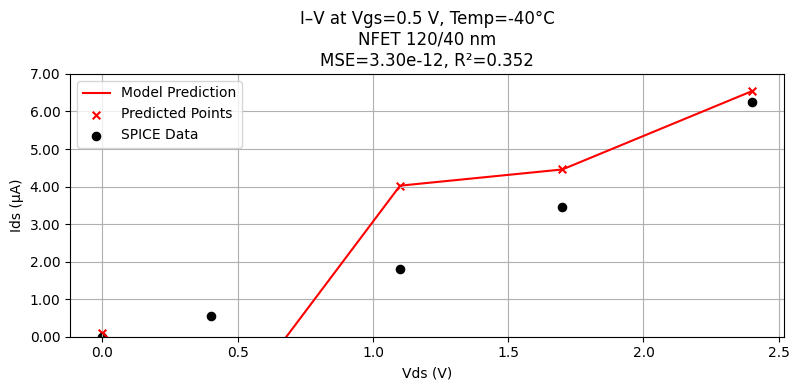

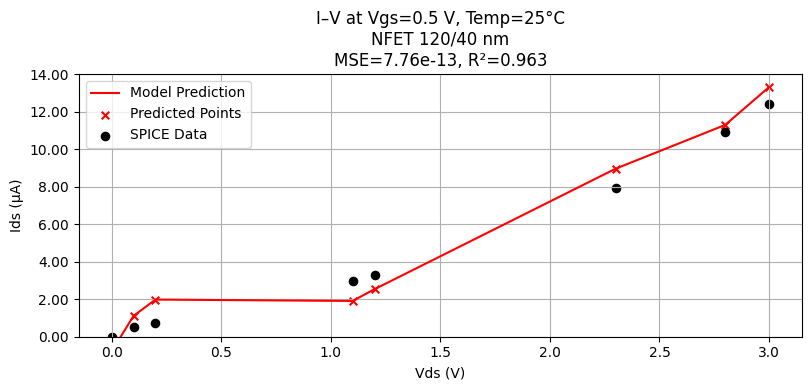

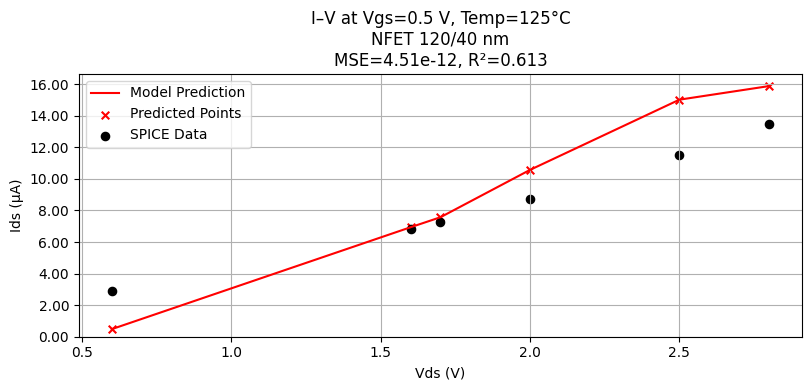

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
from scipy.special import erf

# Load dataset
df = pd.read_csv('/content/nfet_120_40.CSV')
df = df[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['Temp', 'Vgs', 'Vds', 'Ids']

# Create input and output arrays
X_full = df[['Vgs', 'Vds', 'Temp']].values
y_full = df['Ids'].values.reshape(-1, 1)

# Split into disjoint training and evaluation sets
X_pool, X_eval, y_pool, y_eval = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initialize with a small training subset from X_pool
np.random.seed(42)
initial_indices = np.random.choice(len(X_pool), size=100, replace=False)
X_train = X_pool[initial_indices]
y_train = y_pool[initial_indices]

# Define models
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(100, 50), (80, 40)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [5000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

def create_gp_model():
    kernel = ConstantKernel(1.0) * (RBF() + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    temp_focus = np.exp(-((X_pool[:, 2] - 25.0) ** 2) / (2 * 50 ** 2))
    return 0.6 * ei + 0.2 * norm_dist + 0.2 * temp_focus

# Active Learning Loop
for i in range(6):
    print(f"Active Learning Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_pool_scaled = scaler_X.transform(X_pool)
    y_nn_scaled = nn_model.predict(X_pool_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X_pool, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X_pool, X_train)
    new_indices = np.argsort(acq_values)[-10:]
    X_new = X_pool[new_indices]
    y_new = y_pool[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))

# Evaluate on X_eval
df_test = pd.DataFrame(X_eval, columns=['Vgs', 'Vds', 'Temp'])
df_test['Ids'] = y_eval.flatten()
temps = [-40, 25, 125]
vgs_values = [0.5, 1.5, 2.5]

for temp in temps:
    for vgs in vgs_values:
        subset = df_test[(np.isclose(df_test['Temp'], temp)) & (np.isclose(df_test['Vgs'], vgs))]
        if subset.empty:
            continue

        X_eval_subset = subset[['Vgs', 'Vds', 'Temp']].values
        y_true = subset['Ids'].values

        X_eval_scaled = scaler_X.transform(X_eval_subset)
        y_nn_scaled = nn_model.predict(X_eval_scaled).reshape(-1, 1)
        y_nn = scaler_y.inverse_transform(y_nn_scaled)
        gp_corr, _ = gp_model.predict(X_eval_subset, return_std=True)
        y_pred = y_nn + gp_corr.reshape(-1, 1)

        sorted_idx = np.argsort(subset['Vds'].values)
        vds_sorted = subset['Vds'].values[sorted_idx]
        y_true_sorted = y_true[sorted_idx]
        y_pred_sorted = y_pred.flatten()[sorted_idx]

        max_current = max(np.max(y_true_sorted), np.max(y_pred_sorted))
        scale_factor = 1e3 if max_current >= 1e-3 else 1e6
        unit_label = 'mA' if scale_factor == 1e3 else 'μA'

        mse = mean_squared_error(y_true_sorted, y_pred_sorted)
        r2 = r2_score(y_true_sorted, y_pred_sorted)

        plt.figure(figsize=(8, 4))
        plt.plot(vds_sorted, y_pred_sorted * scale_factor, 'r-', label='Model Prediction')
        plt.scatter(vds_sorted, y_pred_sorted * scale_factor, color='red', s=30, marker='x', label='Predicted Points')
        plt.scatter(vds_sorted, y_true_sorted * scale_factor, color='black', s=35, marker='o', label='SPICE Data')
        plt.xlabel('Vds (V)')
        plt.ylabel(f'Ids ({unit_label})')
        plt.title(f'I–V at Vgs={vgs} V, Temp={temp}°C\nNFET 120/40 nm\nMSE={mse:.2e}, R²={r2:.3f}')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        ax = plt.gca()
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
        plt.ylim(bottom=0)  # Zoom out y-axis to better visualize fit
        plt.show()
